# MuseX Tutorial, with a Photutils catalog

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tempfile
from astropy.io import fits
from astropy.table import Table
from mpdaf.sdetect import Source

In [3]:
import musex
musex.__version__

'0.3.dev21+gfd78247.d20190412'

## Settings

The settings are specified in a YAML file. MuseX comes with a default settings file (`musex/musex/udf/settings.yaml`) that gives a full example for the UDF, with HST priors.

For this tutorial, we use the `tests/data/settings.yaml` settings file that is also used for the unit tests. Because of this the file contains variables for the paths and db location that we will replace below, to work in a temporary directory, but otherwise you don't need to do this.

The data inside the `tests/` directory is extracted from the HDFS v1.24 dataset, and the catalog was created with [Photutils](http://photutils.readthedocs.io/).

In [4]:
DATADIR = os.path.abspath(os.path.join(os.path.dirname(musex.__file__), '..', 'tests', 'data'))
DATADIR

'/home/simon/dev/musex/tests/data'

In [5]:
tmpdir = tempfile.TemporaryDirectory(prefix='musex.')
tmpdir

<TemporaryDirectory '/tmp/simon/musex.1fgxavlf'>

Let's create a settings file in the temp directory, with correct paths.

In [6]:
settings_file = os.path.join(tmpdir.name, 'settings.yaml')
with open(os.path.join(DATADIR, 'settings.yaml'), 'r') as f:
    out = f.read()

# we replace some variable in the file: path, datadir, and db location
out = out.format(tmpdir=tmpdir.name, datadir=DATADIR, db=os.path.join(tmpdir.name, 'test.db'))

with open(settings_file, 'w') as f:
    f.write(out)
    
print(out)

workdir: '/tmp/simon/musex.1fgxavlf'
db: '/tmp/simon/musex.1fgxavlf/test.db'
show_banner: true
author: 'John Doe'

datasets:
  test:
    version: '1.0'
    prefix: TEST
    images:
      FAKE: '/home/simon/dev/musex/tests/data/image.fits'
  photutils-hdfs:
    prefix: PHU
    masks:
      # mask_tpl, skymask_tpl, skymask
      skymask: '/tmp/simon/musex.1fgxavlf/masks/hdfs/mask-sky.fits'
      mask_tpl: '/tmp/simon/musex.1fgxavlf/masks/hdfs/mask-source-%05d.fits'
  origin:
    prefix: ORIG
    tables:
      lines:
        file: '/home/simon/dev/musex/tests/data/cat_origin_lines.fits'
        idname: 'num_line'
        src_idname: 'ID'
    masks:
      mask_tpl: '/home/simon/dev/musex/tests/data/origin_masks/source-mask-%05d.fits'
      skymask_tpl: '/home/simon/dev/musex/tests/data/origin_masks/sky-mask-%05d.fits'

muse_datasets:
  default: hdfs

  hdfs:
    version: '1.24'
    prefix: MUSE
    datacube: '/home/simon/dev/musex/tests/data/cube.fits'
    # expcube: '/home/simon/dev/musex

## Create the MuseX object

This is the main object to manage all the extraction process below. Settings can also be overridden with additional arguments.

In [7]:
mx = musex.MuseX(settings_file=settings_file, author='SCO')

[INFO] Input catalogs loaded
[INFO] User catalogs loaded

  __  __               __  __
  |  \/  |_   _ ___  ___\ \/ /
  | |\/| | | | / __|/ _ \\  /
  | |  | | |_| \__ \  __//  \
  |_|  |_|\__,_|___/\___/_/\_\


The MUse Source EXtractor :) - v0.3.dev21+gfd78247.d20190412

settings file  : /tmp/simon/musex.1fgxavlf/settings.yaml
muse_dataset   : hdfs
datasets       : test, photutils-hdfs, origin
input_catalogs : photutils, origin
catalogs       : 


### Datasets

A MuseX object can contains several *datasets*, where a `DataSet` object gathers all the data from a dataset:

- For MUSE datasets: image, cube, exposure map.
- For other datasets (e.g. HST): images, ...

A MuseX object is tied to a given **MUSE dataset** (`mx.muse_dataset`). The other datasets are typically added to the sources object during the extraction.

In [8]:
# The MUSE dataset
mx.muse_dataset

<MuseDataSet(prefix=MUSE, version=1.24, 1 datacube, 1 expima, 1 white)>

In [9]:
mx.muse_dataset.cube

<Cube(shape=(200, 90, 90), unit='1e-20 erg / (Angstrom cm2 s)', dtype='None')>

In [10]:
# The other (additional) datasets
mx.datasets

{'test': <DataSet(prefix=TEST, version=1.0, 1 images)>,
 'photutils-hdfs': <DataSet(prefix=PHU, 2 masks)>,
 'origin': <DataSet(prefix=ORIG, 1 tables, 2 masks)>}

In [11]:
mx.datasets['test'].images

{'FAKE': <Image(shape=(90, 90), unit='1e-60 erg / (Angstrom cm2 s)', dtype='None')>}

## Input Catalogs (from source detection, here Photutils)

We have access to a list of input catalogs, defined in the settings file. For the example, the catalog was from the Photutils detection code.

In [12]:
mx.input_catalogs

{'photutils': <InputCatalog('photutils', 0 rows)>,
 'origin': <InputCatalog('origin', 0 rows)>}

In [13]:
photcat = mx.input_catalogs['photutils']

At this point, the catalog is given as a FITS file defined in the settings, and we need to load it in the database.

In [14]:
photcat.ingest_input_catalog()

[INFO] ingesting catalog /home/simon/dev/musex/tests/data/catalog.fits



[INFO] 13 rows inserted


In [15]:
photcat

<InputCatalog('photutils', 13 rows)>

### See available columns, table info

This gives some information about our catalog: number of rows, columns, and some metadata.

In [16]:
photcat.info()

InputCatalog 'photutils' - 13 rows.

Metadata:
- creation_date : 2019-04-12T14:14:28.356778
- type          : input
- parent_cat    : None
- raname        : ra
- decname       : dec
- idname        : id
- maxid         : 13
- query         : None

Columns:
- id             : INTEGER 
- ra             : FLOAT 
- dec            : FLOAT 
- xcentroid      : FLOAT 
- ycentroid      : FLOAT 
- source_sum     : FLOAT 
- source_sum_err : FLOAT 
- area           : FLOAT 
- eccentricity   : FLOAT 
- orientation    : FLOAT 
- ellipticity    : FLOAT 
- elongation     : FLOAT 
- version        : TEXT 


The catalog metadata is also available with the `.meta` attribute:

In [17]:
photcat.meta

OrderedDict([('id', 1),
             ('name', 'photutils'),
             ('creation_date', '2019-04-12T14:14:28.356778'),
             ('type', 'input'),
             ('parent_cat', None),
             ('raname', 'ra'),
             ('decname', 'dec'),
             ('idname', 'id'),
             ('maxid', 13),
             ('query', None)])

## Intro to `Catalog` objects

In MuseX, `Catalog` objects are wrapping a SQL table, using the [dataset](https://dataset.readthedocs.io/en/latest/) and [SQLAlchemy](http://docs.sqlalchemy.org/en/latest/index.html) packages. SQLAlchemy provides a Pythonic interface to the SQL language, and MuseX also provides some higher-level operations.

For instance, to select in the catalog the sources with an ``ID < 5``:

In [18]:
res = photcat.select(whereclause=photcat.c.id < 5, 
                     columns=[photcat.idname, photcat.raname, photcat.decname])
res

<ResultSet(photutils.id < 5)>, 4 results

The result of a selection can be exported as Astropy Table (or the `mpdaf.sdetect.Catalog` wrapper by default).
This shows the complete catalog:

In [19]:
photcat.select().as_table()

id,ra,dec,xcentroid,ycentroid,source_sum,source_sum_err,area,eccentricity,orientation,ellipticity,elongation,version
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3
1,338.22216683331436,-60.56791899034823,84.17464353709585,37.8735833857062,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834,1.0
2,338.223717115442,-60.566030603445334,70.39134668054363,71.85060521460757,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235,1.0
3,338.23122540134506,-60.565947622439595,3.8983534121084236,73.12238343040192,7.717203065752983,2.5785737182307544,37.0,0.37486045077163443,-1.5044325003438939,0.07291875089219557,1.078654110373142,1.0
4,338.23075897015997,-60.56529582206629,8.008507386689562,84.87964684116072,47.56456159427762,3.957137899405799,86.0,0.3618120741766021,1.253981251781708,0.06774894852297164,1.0726724291870011,1.0
5,338.22344426453924,-60.565293950723195,72.78604306409346,85.1304977128141,9.267546605318785,2.891929673071918,43.0,0.34149582905403886,-0.7723162773518457,0.060116710043904065,1.063961888339043,1.0
6,338.23006974404103,-60.56947389750513,14.242037102996946,9.62603692085029,65.34346552938223,4.843022140700766,129.0,0.3788811153062252,-1.56822411586026,0.07455464749975071,1.080560831926303,1.0
7,338.2302119381167,-60.5687317201611,12.959857008648024,22.993210706363516,129.69185087271035,7.112266323040305,284.0,0.4017365013359274,0.4063112561507294,0.08424469234714871,1.0919947628401676,1.0
8,338.2289866204975,-60.56824280312122,23.794820877858843,31.838575804582526,3.1225252524018288,2.0181706293187514,25.0,0.693823639780682,1.2360735732899375,0.2798550445351391,1.38860932429151,1.0
9,338.2256990939331,-60.56919605095256,52.93434534163357,14.762051380534484,27.56038597226143,4.0427991796868215,88.0,0.5158184032950975,-0.3097023334651164,0.14330205158288356,1.1672725513673243,1.0


It is possible to do any SQL selection and choose which columns to get, using the SQLAlchemy syntax:

In [20]:
photcat.select(whereclause=photcat.c.source_sum > 50,
               columns=[photcat.idname, photcat.raname, photcat.decname, 'source_sum', 'area']).as_table()

id,ra,dec,source_sum,area
int64,float64,float64,float64,float64
6,338.23006974404103,-60.56947389750513,65.34346552938223,129.0
7,338.2302119381167,-60.5687317201611,129.69185087271035,284.0


## User catalogs

Input catalogs are kept immutable, instead users can work on a *"user catalog"*. 

User catalogs must be created with the result of a selection. The mandatory columns are `ID`, `RA` and `DEC` (the other columns from the input catalog can be accessed later with a SQL *join*).

So we can create a user catalog named `my_cat`:

In [21]:
res = photcat.select(columns=[photcat.idname, photcat.raname, photcat.decname])
mycat = mx.new_catalog_from_resultset('my_cat', res, drop_if_exists=True)


[INFO] 13 rows inserted


And we can look at the metadata which is stored about our new user catalog:

In [22]:
mycat.info()

Catalog 'my_cat' - 13 rows.

Metadata:
- creation_date : 2019-04-12T14:14:28.680881
- type          : user
- parent_cat    : photutils
- raname        : ra
- decname       : dec
- idname        : id
- maxid         : 13
- query         : None

Columns:
- id  : INTEGER 
- ra  : FLOAT 
- dec : FLOAT 


Note that the segmentation map is inherited from the parent input catalog.

## User catalogs from scratch

User catalogs must be created with the result of a selection. The mandatory columns are `ID`, `RA` and `DEC` (the other columns from the input catalog can be accessed later with a SQL *join*).

In [23]:
catfile = os.path.join(DATADIR, 'catalog.fits')
tbl = Table.read(catfile)
tbl[:2]

id,ra,dec,xcentroid,ycentroid,source_sum,source_sum_err,area,eccentricity,orientation,ellipticity,elongation
,,,pix,pix,,,pix2,,rad,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,338.22216683331436,-60.56791899034823,84.17464353709585,37.8735833857062,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834
2,338.223717115442,-60.566030603445334,70.39134668054363,71.85060521460757,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235


In [24]:
mycat2 = mx.new_catalog('my_cat2', drop_if_exists=True, idname='id', raname='ra', decname='dec')

In [25]:
mycat2.insert(tbl)


[INFO] 13 rows inserted


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [26]:
mycat2.info()

Catalog 'my_cat2' - 13 rows.

Metadata:
- creation_date : 2019-04-12T14:14:28.892706
- type          : user
- parent_cat    : None
- raname        : ra
- decname       : dec
- idname        : id
- maxid         : 13
- query         : None

Columns:
- id             : INTEGER 
- ra             : FLOAT 
- dec            : FLOAT 
- xcentroid      : FLOAT 
- ycentroid      : FLOAT 
- source_sum     : FLOAT 
- source_sum_err : FLOAT 
- area           : FLOAT 
- eccentricity   : FLOAT 
- orientation    : FLOAT 
- ellipticity    : FLOAT 
- elongation     : FLOAT 


* * * 

## Restart and use existing catalog (created at previous step)

All of the above is a setup that has to be done only once. Then all the information is stored in the database. Let's restart with a new MuseX object to check that it works.

In [27]:
import musex
mx = musex.MuseX(settings_file=settings_file)

[INFO] Input catalogs loaded
[INFO] User catalogs loaded

  __  __               __  __
  |  \/  |_   _ ___  ___\ \/ /
  | |\/| | | | / __|/ _ \\  /
  | |  | | |_| \__ \  __//  \
  |_|  |_|\__,_|___/\___/_/\_\


The MUse Source EXtractor :) - v0.3.dev21+gfd78247.d20190412

settings file  : /tmp/simon/musex.1fgxavlf/settings.yaml
muse_dataset   : hdfs
datasets       : test, photutils-hdfs, origin
input_catalogs : photutils, origin
catalogs       : my_cat, my_cat2


User catalogs are stored in `mx.catalogs`:

In [28]:
mycat = mx.catalogs['my_cat']
photcat = mx.input_catalogs['photutils']

And we can verify that our sources are still here:

In [29]:
mycat.select(limit=2).as_table()

id,ra,dec
int64,float64,float64
1,338.22216683331436,-60.56791899034823
2,338.223717115442,-60.566030603445334


## Masks

To extract spectra from the cube, we need a mask for each source, and either a global sky mask or one per source. The spectra extraction is done with MPDAF Sources ([mpdaf.sdetect.Source](https://mpdaf.readthedocs.io/en/latest/source.html#)), specifically with the [Source.extract_spectra](https://mpdaf.readthedocs.io/en/latest/api/mpdaf.sdetect.Source.html#mpdaf.sdetect.Source.extract_spectra) method. To do this we need to put a sub-cube and the masks in the `Source` object.

There are multiple ways to extract the masks. Some tools (e.g. ORIGIN) provide the masks. Another method is to use a segmentation map. Here we use:

* ORIGIN: the masks computed by ORIGIN are available with the "origin" dataset.
* photutils: an associated segmentation map was computed with photutils' [detect_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html) and [deblend_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html) functions.

To help creating the masks from a segmentation map, there is the `MuseX.create_masks_from_segmap` method, which itself uses [create_masks_from_segmap](https://mpdaf.readthedocs.io/en/latest/api/mpdaf.sdetect.create_masks_from_segmap.html) from MPDAF.

This can also be used for an HST segmentation map, and it will take care of aligning the segmap and putting to the MUSE resolution.

In [30]:
maskdir = os.path.join(mx.workdir, 'masks', 'hdfs')
mx.create_masks_from_segmap(photcat, maskdir, skip_existing=True)

[INFO] read catalog /home/simon/dev/musex/tests/data/catalog.fits with 13 sources
[INFO] selected 13 sources in dataset footprint
[INFO] Aligning segmap with reference image
[INFO] computing masks for 10 sources


In [31]:
print('work dir:', mx.workdir)
sorted(os.listdir(maskdir))

work dir: /tmp/simon/musex.1fgxavlf


['mask-sky.fits',
 'mask-source-00001.fits',
 'mask-source-00002.fits',
 'mask-source-00003.fits',
 'mask-source-00004.fits',
 'mask-source-00005.fits',
 'mask-source-00006.fits',
 'mask-source-00007.fits',
 'mask-source-00008.fits',
 'mask-source-00009.fits',
 'mask-source-00010.fits']

Then the masks must be declared in the settings file.

In [32]:
mx.conf['datasets']['photutils-hdfs']['masks']

{'skymask': '/tmp/simon/musex.1fgxavlf/masks/hdfs/mask-sky.fits',
 'mask_tpl': '/tmp/simon/musex.1fgxavlf/masks/hdfs/mask-source-%05d.fits'}

In [33]:
mx.conf['datasets']['origin']['masks']

{'mask_tpl': '/home/simon/dev/musex/tests/data/origin_masks/source-mask-%05d.fits',
 'skymask_tpl': '/home/simon/dev/musex/tests/data/origin_masks/sky-mask-%05d.fits'}

## Origin

We also have the possibility to ingest a catalog from the ORIGIN detection software. This catalog is associated to a line catalog, which contains the individual line detections.

In [34]:
origcat = mx.input_catalogs['origin']

In [35]:
origcat.ingest_input_catalog()

[INFO] ingesting catalog /home/simon/dev/musex/tests/data/cat_origin.fits



[INFO] 10 rows inserted


In [36]:
myori = mx.new_catalog_from_resultset('my_oricat', origcat.select())


[INFO] 10 rows inserted


The ORIGIN input data also includes pre-generated masks, which are defined in the YAML file with ``mask_tpl`` and ``skymask_tpl``.

In [37]:
myori.select(limit=2).as_table()

ID,ra,dec,x,y,n_lines,seg_label,comp,line_merged_flag,version
int64,float64,float64,float64,float64,int64,int64,int64,bool,str3
0,338.23009603091447,-60.569175573853556,14.0,15.0,0,6,0,False,1.0
1,338.228065721342,-60.569900508634014,32.0,2.0,0,0,0,False,1.0


## Export sources

In [38]:
mx.datasets

{'test': <DataSet(prefix=TEST, version=1.0, 1 images)>,
 'photutils-hdfs': <DataSet(prefix=PHU, 2 masks)>,
 'origin': <DataSet(prefix=ORIG, 1 tables, 2 masks)>}

In [39]:
mx.export_sources(mycat.select(limit=2).as_table(), masks_dataset='photutils-hdfs')

[INFO] Exporting 2 sources with hdfs dataset, size=5.0
[WARNING] 'QOP' column not found, though it is specified in the settings file for the CONFID keyword
[WARNING] 'Blend' column not found, though it is specified in the settings file for the BLEND keyword
[WARNING] 'Defect' column not found, though it is specified in the settings file for the DEFECT keyword
[WARNING] 'Revisit' column not found, though it is specified in the settings file for the REVISIT keyword
[WARNING] 'Type' column not found, though it is specified in the settings file for the TYPE keyword
[WARNING] 'refspec' column not found, though it is specified in the settings file for the REFSPEC keyword
[WARNING] 'Comment' column not found, though it is specified in the settings file for the COMMENT keyword


[WARNING] REFSPEC column not found, using MUSE_TOT_SKYSUB instead
[WARNING] REFSPEC column not found, using MUSE_TOT_SKYSUB instead



In [40]:
os.listdir(os.path.join(mx.exportdir, mycat.name, 'sources'))

['source-00002.fits', 'source-00001.fits']

In [41]:
mx.export_sources(myori.select(limit=2).as_table(), masks_dataset='origin')

[INFO] Exporting 2 sources with hdfs dataset, size=5.0
[WARNING] 'QOP' column not found, though it is specified in the settings file for the CONFID keyword
[WARNING] 'Blend' column not found, though it is specified in the settings file for the BLEND keyword
[WARNING] 'Defect' column not found, though it is specified in the settings file for the DEFECT keyword
[WARNING] 'Revisit' column not found, though it is specified in the settings file for the REVISIT keyword
[WARNING] 'Type' column not found, though it is specified in the settings file for the TYPE keyword
[WARNING] 'refspec' column not found, though it is specified in the settings file for the REFSPEC keyword
[WARNING] 'Comment' column not found, though it is specified in the settings file for the COMMENT keyword


[WARNING] REFSPEC column not found, using MUSE_TOT_SKYSUB instead
[WARNING] REFSPEC column not found, using MUSE_TOT_SKYSUB instead



In [42]:
os.listdir(os.path.join(mx.exportdir, myori.name, 'sources'))

['source-00001.fits', 'source-00000.fits']

In [43]:
src = Source.from_file(os.path.join(mx.exportdir, myori.name, 'sources', 'source-00001.fits'))
src.info()

[INFO] ID      =                    1 / object ID %d                                   
[INFO] RA      =     338.228065721342 / RA u.degree %.7f                               
[INFO] DEC     =   -60.56990050863401 / DEC u.degree %.7f                              
[INFO] FROM    = 'MuseX   '           / detection software                             
[INFO] FROM_V  = '0.3.dev21+gfd78247.d20190412' / version of the detection software    
[INFO] CUBE    = 'cube.fits'          / datacube                                       
[INFO] CUBE_V  = '1.24    '           / version of the datacube                        
[INFO] SRC_V   = '' / Source Version                                                   
[INFO] SIZE    =                    5                                                  
[INFO] EXPMEAN =                 52.0 / Mean value of EXPMAP                           
[INFO] EXPMIN  =                   52 / Minimum value of EXPMAP                        
[INFO] EXPMAX  =                

## MarZ export and import

First, we need to set the `REFSPEC` column to tell which spectrum must be used : (this may change later to allow more flexibility, currently it is possible to set a `refspec` value for each source).

In [44]:
mycat.update_column('refspec', 'MUSE_PSF_SKYSUB')

[INFO] creating column 'my_cat.refspec'


In [45]:
mx.export_marz(mycat.select(limit=2), masks_dataset='photutils-hdfs')

[INFO] Saving sources to /tmp/simon/musex.1fgxavlf/export/hdfs/my_cat/marz/source-{src.ID:05d}.fits
[INFO] Exporting 2 sources with hdfs dataset, size=5.0
[WARNING] 'QOP' column not found, though it is specified in the settings file for the CONFID keyword
[WARNING] 'Blend' column not found, though it is specified in the settings file for the BLEND keyword
[WARNING] 'Defect' column not found, though it is specified in the settings file for the DEFECT keyword
[WARNING] 'Revisit' column not found, though it is specified in the settings file for the REVISIT keyword
[WARNING] 'Type' column not found, though it is specified in the settings file for the TYPE keyword
[WARNING] 'Comment' column not found, though it is specified in the settings file for the COMMENT keyword



[INFO] Writing /tmp/simon/musex.1fgxavlf/export/hdfs/my_cat/marz/marz-my_cat-hdfs.fits


Once the spectra have been processed in MarZ, the results file can be ingested into MuseX:

In [46]:
mx.import_marz(os.path.join(DATADIR, 'marz-my-cat-hdfs_full_SCO.mz'), mycat)

[INFO] ingesting catalog



[INFO] 13 rows inserted


In [47]:
mx.marzcat.info()

MarzCatalog 'marz' - 13 rows.

Metadata:
- creation_date : 2019-04-12T14:14:35.831955
- type          : marz
- parent_cat    : None
- raname        : RA
- decname       : DEC
- idname        : ID
- maxid         : 13
- query         : None
- version_meta  : None
- CAT3_TS       : None

Columns:
- _id      : INTEGER 
- ID       : INTEGER 
- RA       : FLOAT 
- DEC      : FLOAT 
- Mag      : FLOAT 
- Type     : INTEGER 
- AutoTID  : INTEGER 
- AutoTN   : TEXT 
- AutoZ    : FLOAT 
- AutoXCor : FLOAT 
- FinTID   : INTEGER 
- FinTN    : TEXT 
- FinZ     : FLOAT 
- QOP      : INTEGER 
- Blend    : INTEGER 
- Defect   : INTEGER 
- Revisit  : INTEGER 
- HstIds   : TEXT 
- Comment  : TEXT 
- catalog  : TEXT 
- version  : TEXT 


In [48]:
mx.marzcat.select(limit=3).as_table()

_id,ID,RA,DEC,Mag,Type,AutoTID,AutoTN,AutoZ,AutoXCor,FinTID,FinTN,FinZ,QOP,Blend,Defect,Revisit,HstIds,Comment,catalog,version
int64,int64,float64,float64,float64,int64,int64,str55,float64,float64,int64,str55,float64,int64,int64,int64,int64,str5,str1,str6,str1
1,1,338.222167,-60.567919,-99.0,0,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,9.79608,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,2,0,0,0,--,--,my_cat,1
2,2,338.223717,-60.566031,-99.0,2,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,11.90192,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,2,0,0,0,24348,--,my_cat,1
3,3,338.231225,-60.565948,-99.0,6,18,MUSE-42 HDF-S z-bin 5 - Ly-a emitter - weak continuum,3.0343,25.8933,18,MUSE-42 HDF-S z-bin 5 - Ly-a emitter - weak continuum,3.0343,3,0,0,0,24353,--,my_cat,1


## Joining catalogs

When the user catalog is ready to be exported, one need to gather the data from multiple catalogs (the input catalog, MarZ, etc.). This can be done with a SQL *join*.

By default `.join` renames the columns with the format `{catname}_{colname}` to avoid name conflicts. But it is also possible to specify manually the column names (see below).

In [49]:
res = mycat.join([photcat, mx.marzcat], whereclause=(mx.marzcat.c.catalog == mycat.name))
res.as_table()[:2]

my_cat_id,my_cat_ra,my_cat_dec,my_cat_refspec,photutils_id,photutils_ra,photutils_dec,photutils_xcentroid,photutils_ycentroid,photutils_source_sum,photutils_source_sum_err,photutils_area,photutils_eccentricity,photutils_orientation,photutils_ellipticity,photutils_elongation,photutils_version,marz__id,marz_ID,marz_RA,marz_DEC,marz_Mag,marz_Type,marz_AutoTID,marz_AutoTN,marz_AutoZ,marz_AutoXCor,marz_FinTID,marz_FinTN,marz_FinZ,marz_QOP,marz_Blend,marz_Defect,marz_Revisit,marz_HstIds,marz_Comment,marz_catalog,marz_version
int64,float64,float64,str15,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,int64,int64,float64,float64,float64,int64,int64,str57,float64,float64,int64,str57,float64,int64,int64,int64,int64,str5,str1,str6,str1
1,338.22216683331436,-60.56791899034823,MUSE_PSF_SKYSUB,1,338.22216683331436,-60.56791899034823,84.17464353709585,37.8735833857062,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834,1.0,1,1,338.222167,-60.567919,-99.0,0,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,9.79608,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,2,0,0,0,--,--,my_cat,1
2,338.223717115442,-60.566030603445334,MUSE_PSF_SKYSUB,2,338.223717115442,-60.566030603445334,70.39134668054363,71.85060521460757,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235,1.0,2,2,338.223717,-60.566031,-99.0,2,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,11.90192,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,2,0,0,0,24348,--,my_cat,1


## Select columns for the final catalog

To avoid column name conflicts, for now the user needs to select explicitely the columns and rename if needed. This must be done with SQLAlchemy columns objects:

In [50]:
str(photcat.c)

"['photutils.id', 'photutils.ra', 'photutils.dec', 'photutils.xcentroid', 'photutils.ycentroid', 'photutils.source_sum', 'photutils.source_sum_err', 'photutils.area', 'photutils.eccentricity', 'photutils.orientation', 'photutils.ellipticity', 'photutils.elongation', 'photutils.version']"

In [51]:
photcols = [photcat.c[name] for name in ['source_sum', 'source_sum_err', 'area', 'eccentricity', 
                                         'orientation', 'ellipticity', 'elongation', 'version']]

marzcols = [mx.marzcat.c[name] for name in ('FinZ', 'QOP', 'Type', 'Blend', 'Defect', 'Revisit', 'Comment')]

It is possible to rename a column with `.label`:

In [52]:
photcols[2] = photcols[2].label('pixel_area')

Then we concatenate the column names from the user catalog, MarZ, and the input catalog:

In [53]:
mycat.c + marzcols + photcols

[Column('id', INTEGER(), table=<my_cat>, primary_key=True, nullable=False),
 Column('ra', FLOAT(), table=<my_cat>),
 Column('dec', FLOAT(), table=<my_cat>),
 Column('refspec', TEXT(), table=<my_cat>),
 Column('FinZ', FLOAT(), table=<marz>),
 Column('QOP', INTEGER(), table=<marz>),
 Column('Type', INTEGER(), table=<marz>),
 Column('Blend', INTEGER(), table=<marz>),
 Column('Defect', INTEGER(), table=<marz>),
 Column('Revisit', INTEGER(), table=<marz>),
 Column('Comment', TEXT(), table=<marz>),
 Column('source_sum', FLOAT(), table=<photutils>),
 Column('source_sum_err', FLOAT(), table=<photutils>),
 Column('eccentricity', FLOAT(), table=<photutils>),
 Column('orientation', FLOAT(), table=<photutils>),
 Column('ellipticity', FLOAT(), table=<photutils>),
 Column('elongation', FLOAT(), table=<photutils>),
 Column('version', TEXT(), table=<photutils>)]

And we can proceed with the join. Note that by default the join uses the `id` column of each catalog, but it is possible to specify others keys with the `keys` arguments. Also, the `mx.marzcat` table can store the results for multiple catalogs, so we need to select the results for our catalog with the `whereclause`:

In [54]:
res = mycat.join(
    [mx.marzcat, photcat], 
    whereclause=(mx.marzcat.c.catalog == mycat.name), 
    columns=mycat.c + marzcols + photcols, 
    use_labels=False,
    limit=2
).as_table()
res

id,ra,dec,refspec,FinZ,QOP,Type,Blend,Defect,Revisit,Comment,source_sum,source_sum_err,pixel_area,eccentricity,orientation,ellipticity,elongation,version
int64,float64,float64,str15,float64,int64,int64,int64,int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,str3
1,338.22216683331436,-60.56791899034823,MUSE_PSF_SKYSUB,-0.00258,2,0,0,0,0,--,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834,1.0
2,338.223717115442,-60.566030603445334,MUSE_PSF_SKYSUB,0.31325,2,2,0,0,0,--,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235,1.0


## Export sources

In [55]:
# Set the REFSPEC column to tell which spectrum must be used 
# mycat.update_column('refspec', 'MUSE_PSF_SKYSUB')

Currently, to get a redshift and confidence number in the `Source` objects, MuseX looks at specific columns (`Z` and `Confid`) in the table. So here we rename the columns (we could have done this within the SQL join above, with `.label`):

In [56]:
res.rename_column('FinZ', 'Z')
#res.rename_column('QOP', 'Confid')

In [57]:
res

id,ra,dec,refspec,Z,QOP,Type,Blend,Defect,Revisit,Comment,source_sum,source_sum_err,pixel_area,eccentricity,orientation,ellipticity,elongation,version
int64,float64,float64,str15,float64,int64,int64,int64,int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,str3
1,338.22216683331436,-60.56791899034823,MUSE_PSF_SKYSUB,-0.00258,2,0,0,0,0,--,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834,1.0
2,338.223717115442,-60.566030603445334,MUSE_PSF_SKYSUB,0.31325,2,2,0,0,0,--,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235,1.0


And we do the export, here for only one source selected by its ID. We also ask for the creation of a PDF file with plots:

In [58]:
mx.export_sources(res, create_pdf=True, size=5, srcvers='0.1', apertures=[0.4], masks_dataset='photutils-hdfs')

[INFO] Exporting 2 sources with hdfs dataset, size=5.0


The output files are placed in the *work directory*:

In [59]:
outdir = os.path.join(mx.exportdir, mycat.name, 'sources')
print(outdir)
sorted(os.listdir(outdir))

/tmp/simon/musex.1fgxavlf/export/hdfs/my_cat/sources


['source-00001.fits',
 'source-00001.pdf',
 'source-00002.fits',
 'source-00002.pdf']

A MPDAF source file has been generated, with all the information both in the header and in the extensions (images, spectra):

In [60]:
from mpdaf.sdetect import Source
Source.from_file(f'{outdir}/source-00001.fits').info()

[INFO] ID      =                    1 / object ID %d                                   
[INFO] RA      =    338.2221668333144 / RA u.degree %.7f                               
[INFO] DEC     =   -60.56791899034823 / DEC u.degree %.7f                              
[INFO] FROM    = 'MuseX   '           / detection software                             
[INFO] FROM_V  = '0.3.dev21+gfd78247.d20190412' / version of the detection software    
[INFO] CUBE    = 'cube.fits'          / datacube                                       
[INFO] CUBE_V  = '1.24    '           / version of the datacube                        
[INFO] SRC_V   = '0.1     '           / Source Version                                 
[INFO] SIZE    =                    5                                                  
[INFO] EXPMEAN =                 51.0 / Mean value of EXPMAP                           
[INFO] EXPMIN  =                   51 / Minimum value of EXPMAP                        
[INFO] EXPMAX  =                

A PDF file was generated as well.

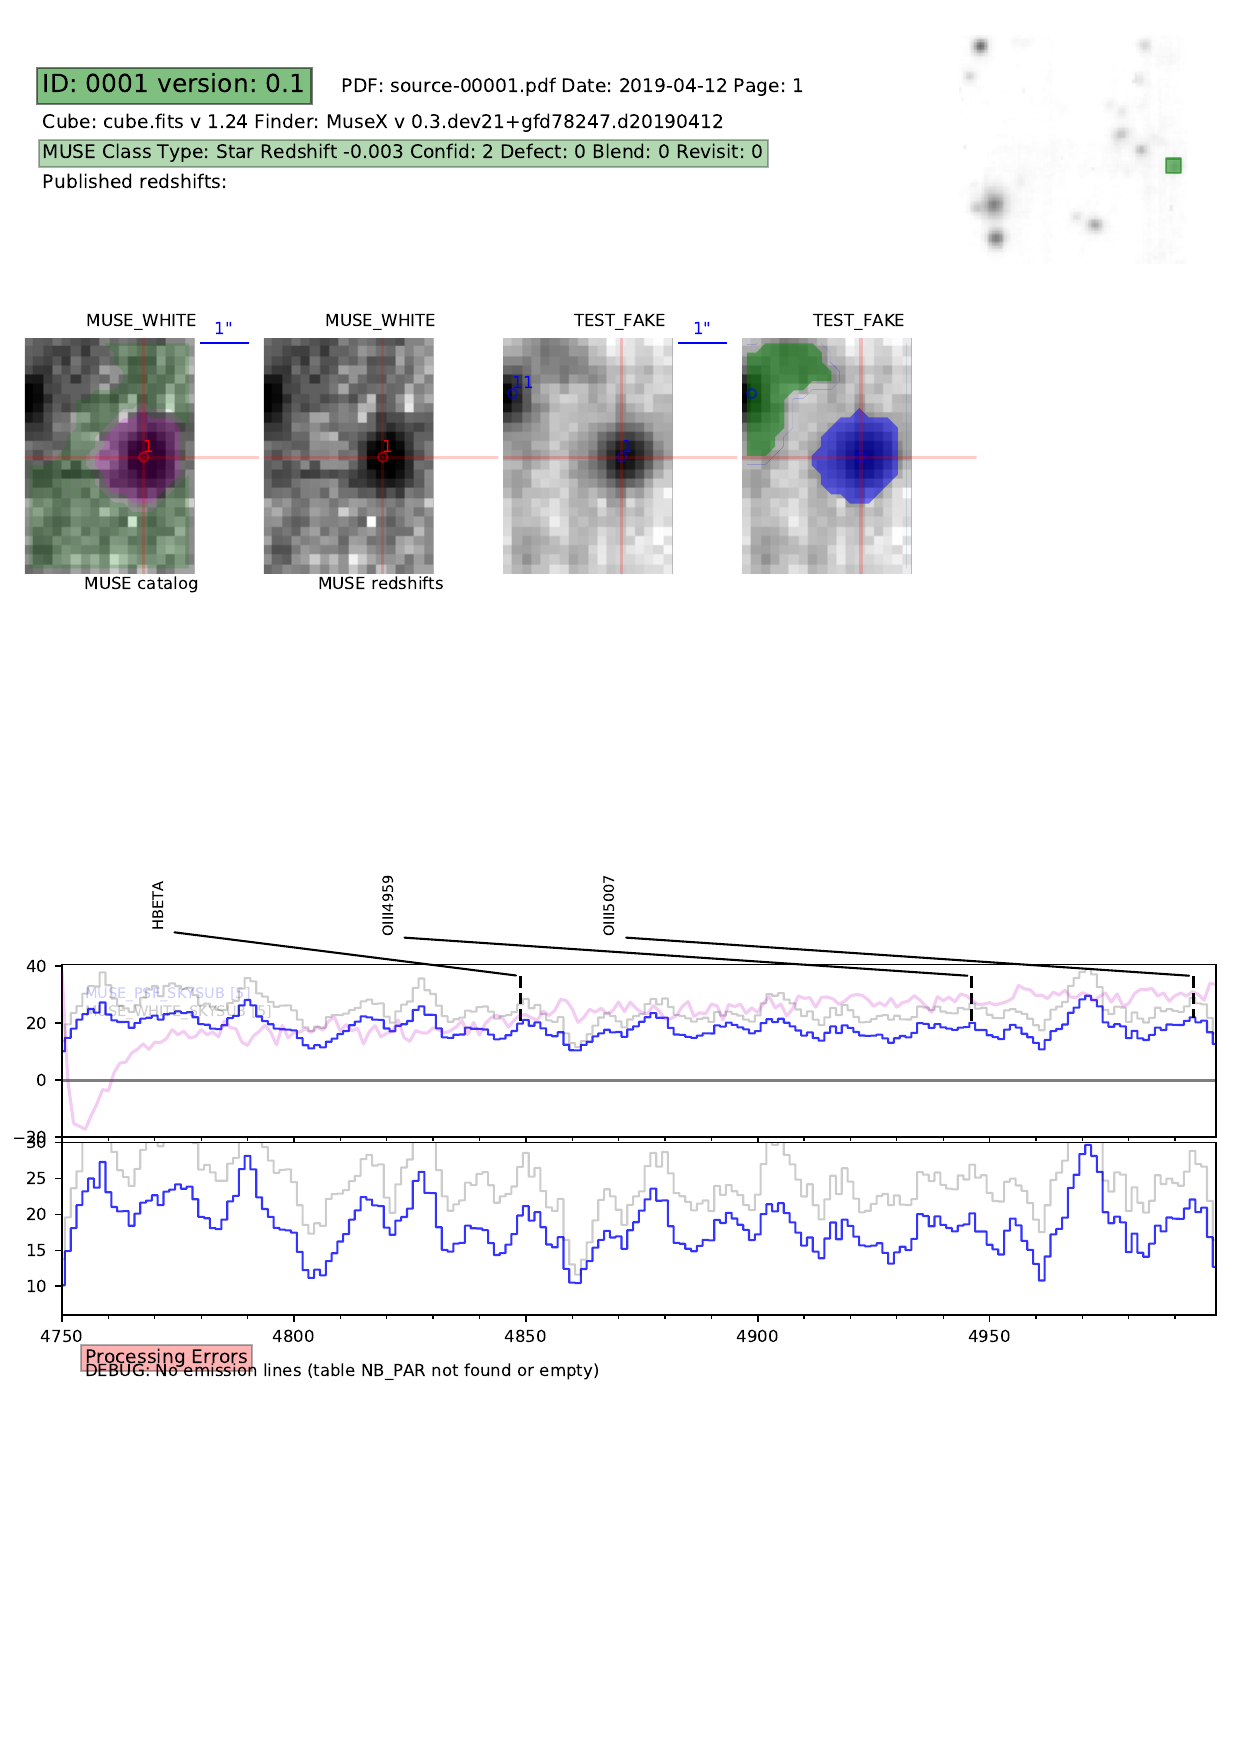

In [61]:
import subprocess
subprocess.run(f'pdftoppm -singlefile {outdir}/source-00001.pdf {tmpdir.name}/out && convert {tmpdir.name}/out.ppm {tmpdir.name}/out.png', shell=True)

from IPython.display import Image
display(Image(f'{tmpdir.name}/out.png'))

In [66]:
# import webbrowser
# webbrowser.open(f'{outdir}/source-00001.pdf')

In [68]:
# from IPython.display import IFrame
# display(IFrame(f'{outdir}/source-00001.pdf', width=600, height=300))

In [69]:
# Cleanup temp directory
tmpdir.cleanup()